## Step 4: UV mapping $S_{ref}(x,y,z)$ using its equiareal spherical parameterization, $S_{\Omega}(x,y,z)$

The spherical parameterization is a mesh which is an unstructured data format such that the mesh vertices randomly sample the 3D sphere in a manner that is not correspondent to the 2D plane. This workbook works through how to do the resampling to get 1-1 correspondence and map the 3D sphere to the 2D plane. 

### Load $S_{ref}(x,y,z)$ and $S_{\Omega}(x,y,z)$ meshes and create an analysis save folder

We assume the user has worked through step 3 which generates and saves the equiareal parameterization $S_{\mathcal{\Omega}}(x,y,z)$ of the genus-0 reference surface for an input cell surface mesh to the folder `example_results/bleb_example/step3_equiareal_sphere_param`. We also need the reference surface from step 1 saved to the folder `example_results/bleb_example/step1_cMCF_reference`. Moreover these surface has been colored by curvature or molecular intensity. 

In [1]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import scipy.io as spio

# example cell used
imgfolder = 'example_data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step4_uv_mapping')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


# load the pre-computed genus-0 reference, S_ref(x,y,z)
S_ref_folder = 'example_results/%s/step1_cMCF_reference' %(basefname)
S_ref_file = os.path.join(S_ref_folder, 
                            'unwrap_cMCF_Sref_mesh_H_color.obj') 
S_ref_mesh = meshtools.read_mesh(S_ref_file)

# load the pre-computed genus-0 spherical parameterization of S_ref(x,y,z)
equiareal_folder = 'example_results/%s/step3_equiareal_sphere_param' %(basefname)
equiareal_file = os.path.join(equiareal_folder, 
                               'equiareal_sphere_param_Sref_%s.obj' %(basefname))
equiareal_sphere_mesh = meshtools.read_mesh(equiareal_file)

### Setting up the rectangular UV grid

Our spherical parameterization is in the form of a mesh whose vertices are not those of points on a rectangular grid after converting to spherical coordinates with radius=1. 

In order to unwrap we need to resample the spherical parameterization at those points on the rectangular grid after converting to their spherical coordinates with radius=1. 

In [2]:
import unwrap3D.Geometry.geometry as geometry

size = 256 # the larger the more hi-res but at the expense of computational cost and memory efficiency

# set up a Nx2N uv grid by specifying the azimuthal and polar angles
ang_grid = geometry.img_2_angles(size, 2*size)  
unit_sphere_xyz = geometry.sphere_from_img_angles(ang_grid.reshape(-1,ang_grid.shape[-1]))
unit_sphere_xyz = unit_sphere_xyz.reshape((size,2*size,3))


we can visualise the grid to see how the 2D grid maps onto the standard unit sphere. We can do this easily by uv texture mapping. Specifically we will define a colormap from the top-left to the bottom-right of the uv grid and visualize this on the corresponding 3D (x,y,z). 

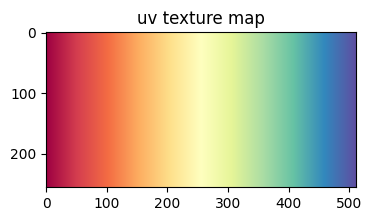

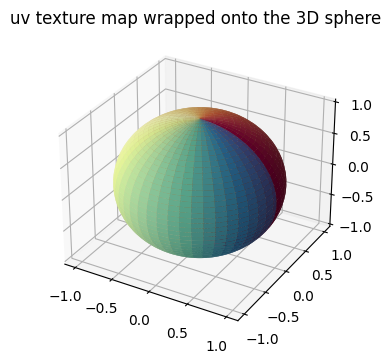

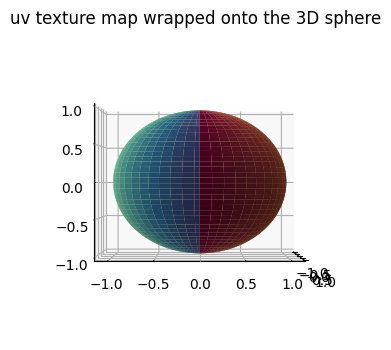

In [3]:
import unwrap3D.Visualisation.colors as vol_colors
from matplotlib import cm
import pylab as plt 

# colormap the uv grid with a continuous gradient colorscheme of the latitude lines 
unit_sphere_uv_labelgrid = np.arange(np.prod([size,2*size])).reshape(size,2*size, order='F') 
unit_sphere_uv_colormap = vol_colors.get_colors(unit_sphere_uv_labelgrid, colormap=cm.Spectral)

# visualize the uv texture colormap
plt.figure(figsize=(4,4))
plt.title('uv texture map')
plt.imshow(unit_sphere_uv_colormap)
plt.show()

# visualize the uv texture colormap wrapped onto the coordinates specified by unit_sphere_xyz
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(projection='3d')
plt.title('uv texture map wrapped onto the 3D sphere')
ax.plot_surface(unit_sphere_xyz[...,0], 
                unit_sphere_xyz[...,1], 
                unit_sphere_xyz[...,2], 
                facecolors=unit_sphere_uv_colormap, linewidth=0)


fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(projection='3d')
plt.title('uv texture map wrapped onto the 3D sphere')
ax.plot_surface(unit_sphere_xyz[...,0], 
                unit_sphere_xyz[...,1], 
                unit_sphere_xyz[...,2], 
                facecolors=unit_sphere_uv_colormap, linewidth=0)
ax.view_init(0,0)
plt.show()


### **Optional**: Automatic determination of optimal uv-unwrapping axis

By default, the spherical grid as defined will uv-unwrap $S_{ref}(x,y,z)$ in its native north-south axis. UV-unwrapping introduces greatest distortion near the poles. This might not be desirable if one wishes to do analysis of the surface protrusions where ideally all protrusions are unwrapped with minimal areal distortion. 

We can find a 'rotation' of $S_{ref}(x,y,z)$ through $S_{\Omega}(x,y,z)$ to map protrusions with minimal areal distortion using weighted principal components analysis where we assign a weight of importance to every point on the mesh. 


In [4]:
"""
Weight assignment - here we are going to use the absolute mean curvature of S_ref
"""
import igl
import numpy as np 

# instead of computing from a volume binary, which would involve mesh voxelization etc. we are going to compute mean curvature directly from the mesh using the definition that it is the mean of the 2 principal curvatures
v1, v2, k1, k2 = igl.principal_curvature(S_ref_mesh.vertices,
                                         S_ref_mesh.faces)
H_Sref = -1*0.5*(k1+k2) # we need to multiply this by -1 to get the intuitive idea that a round protrusion = positive curvature

# define weights
weights = np.abs(H_Sref)

"""
Weighted PCA to solve for the optimal rotation 
"""
# solve the weighted PCA to get the eigenvalues (w_axis) and eigenvectors (v_axis). Result is sorted in terms of increasing eigenvalue
w_axis, v_axis = meshtools.find_principal_axes_surface_heterogeneity_mesh(equiareal_sphere_mesh.vertices, 
                                                                          equiareal_sphere_mesh.faces,
                                                                          weights)
# PCA solution yields orthonormal matrices with determinants of +/-1, only +1 is a proper rotations
v_axis = geometry.fix_improper_rot_matrix_3D(v_axis) # make the outcome a proper rotation
v_axis = v_axis[:,::-1].copy() # flipping so that the smallest eigenvector corresponds to the sphere's North-South axis i.e. z-coordinate in our system.

"""
Optimal rotation matrix is given by the matrix inverse (which is the transpose for orthonormal matrices) of the eigenvector matrix. 
"""
# this is the optimal rotation we need to apply to equiareal_sphere_mesh.
# note we do not need to do anything to S_ref_mesh, as its points are in bijection !
rot_matrix = geometry.rotmatrix3D_to_4D(v_axis).T 


"""
apply rotation matrix to equiareal_sphere_mesh
"""
equiareal_sphere_mesh_rot = equiareal_sphere_mesh.copy()
equiareal_sphere_mesh_rot.vertices = geometry.rot_pts_xyz(equiareal_sphere_mesh.vertices, 
                                                        rot_matrix, 
                                                        mean_pts=np.hstack([0,0,0]), # supply a rotation center, which is just the origin 
                                                        demean_pts=True)



We visualize the effect of the rotation in matplotlib, overlaying the unit sphere uv grid onto S_ref with and without the rotation. As can be seen, it has shifted a large protrusion that was near the pole away. The effect is more apparent once we uv-unwrap. 

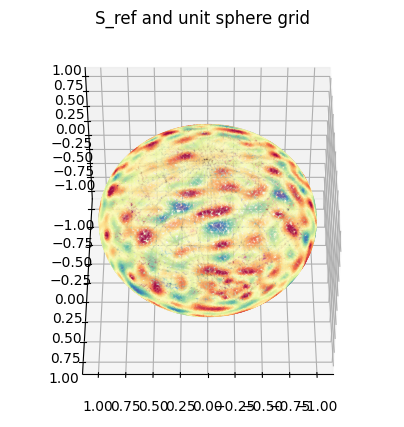

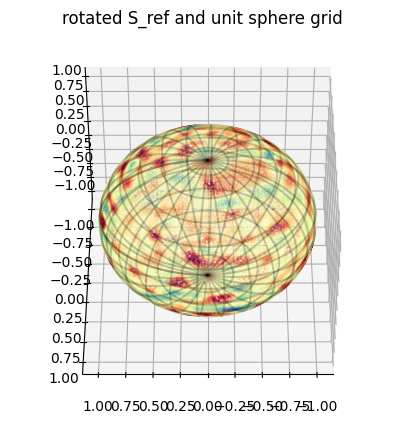

In [5]:
import unwrap3D.Visualisation.plotting as plotting 
import pylab as plt 

sampling = 2

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
plt.title('S_ref and unit sphere grid')
ax.scatter(equiareal_sphere_mesh.vertices[::sampling,2], 
           equiareal_sphere_mesh.vertices[::sampling,1],
           equiareal_sphere_mesh.vertices[::sampling,0], 
           s=0.1,
           c=equiareal_sphere_mesh.visual.vertex_colors[::sampling,:3]/255.)
ax.plot_wireframe(unit_sphere_xyz[...,0], 
                  unit_sphere_xyz[...,1], 
                  unit_sphere_xyz[...,2], 
                  color='k',
                 rstride=20, cstride=20, zorder=1000, alpha=0.2)
ax.view_init(45,90)
plt.show()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
plt.title('rotated S_ref and unit sphere grid')
ax.scatter(equiareal_sphere_mesh_rot.vertices[::sampling,2], 
           equiareal_sphere_mesh_rot.vertices[::sampling,1],
           equiareal_sphere_mesh_rot.vertices[::sampling,0], 
           s=0.1,
           c=equiareal_sphere_mesh.visual.vertex_colors[::sampling,:3]/255.)
ax.plot_wireframe(unit_sphere_xyz[...,0], 
                unit_sphere_xyz[...,1], 
                unit_sphere_xyz[...,2], 
                color='k',
                 rstride=20, cstride=20, zorder=1000, alpha=0.2)
ax.view_init(45,90)
plt.show()

### UV-unwrapping by 'pullback'

To unwrap, we match the equiareal parameterization (rotated or nonrotated) to the standard uv-sphere grid defined at the start. We can then map $S_{ref}(x,y,z)$ into the uv-space and any other scalar quantity by barycentric interpolation. 

In [6]:
"""
Matching equiareal to unit sphere
"""
uv_Sref_equiareal_match = meshtools.match_and_interpolate_uv_surface_to_mesh(unit_sphere_xyz.reshape(-1,3), 
                                                                             equiareal_sphere_mesh, 
                                                                             match_method='cross')

"""
Matching equiareal rotated to unit sphere
"""
uv_Sref_equiareal_match_rot = meshtools.match_and_interpolate_uv_surface_to_mesh(unit_sphere_xyz.reshape(-1,3), 
                                                                             equiareal_sphere_mesh_rot, 
                                                                             match_method='cross')

"""
Barycentric interpolation to pull down S_ref with matching equiareal
"""
S_uv = meshtools.mesh_vertex_interpolate_scalar(equiareal_sphere_mesh, 
                                                uv_Sref_equiareal_match[0], 
                                                uv_Sref_equiareal_match[1], 
                                                S_ref_mesh.vertices)
S_uv = S_uv.reshape((size,2*size,-1)) 

"""
Barycentric interpolation to pull down S_ref with matching equiareal rotated 
"""
S_uv_rot = meshtools.mesh_vertex_interpolate_scalar(equiareal_sphere_mesh_rot, 
                                                    uv_Sref_equiareal_match_rot[0], 
                                                    uv_Sref_equiareal_match_rot[1], 
                                                    S_ref_mesh.vertices)
S_uv_rot = S_uv_rot.reshape((size,2*size,-1)) 

We can visualize the change in the uv parameterized shape. By rotating the equiareal spherical parameterization we were able to uv grid $S_{ref}$ without ever rotating it! 

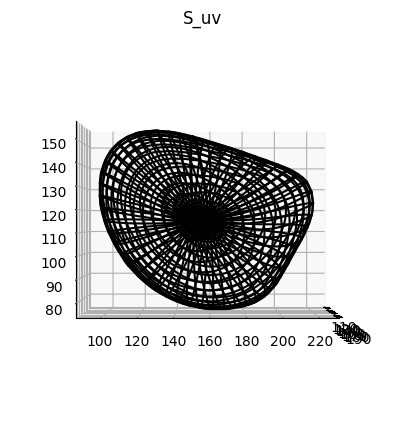

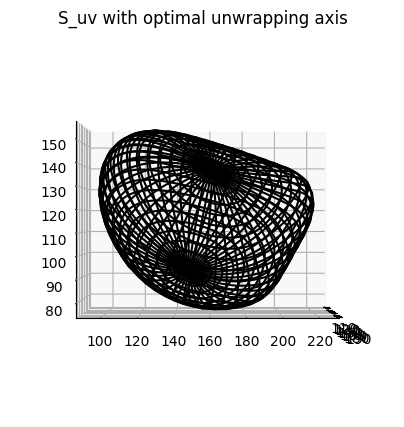

In [7]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
plt.title('S_uv')
ax.plot_wireframe(S_uv[...,2], 
                  S_uv[...,1], 
                  S_uv[...,0], 
                  color='k',
                 rstride=10, cstride=10)
ax.view_init(0,0)
plt.show()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
plt.title('S_uv with optimal unwrapping axis')
ax.plot_wireframe(S_uv_rot[...,2], 
                  S_uv_rot[...,1], 
                  S_uv_rot[...,0], 
                  color='k',
                 rstride=10, cstride=10)
ax.view_init(0,0)
plt.show()


We can see more clearly the effect of this on the uv-unwrap by mapping now the curvature of $S(x,y,z)$ into the two different (u,v) parameterizations  

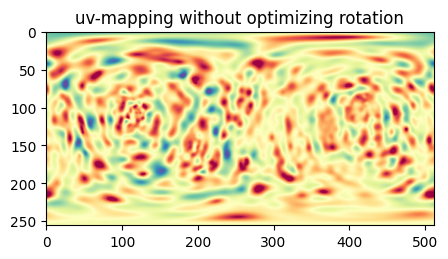

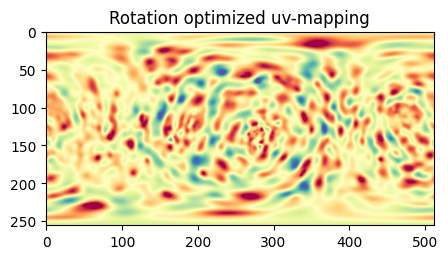

In [8]:
# First, we can't interpolate colors, therefore we need to load in previously computed surface curvature values.
curvature_stats_file = os.path.join(S_ref_folder, 
                                     'unwrap_cMCF_remapped_surf_H.mat') 
surf_H = np.squeeze(spio.loadmat(curvature_stats_file)["surf_H"].copy())


# """
# 1. Barycentric interpolation of S(x,y,z) curvature mapped onto remeshed S_ref, into S_uv 
# """
Sref_uv_H = meshtools.mesh_vertex_interpolate_scalar(S_ref_mesh, 
                                                      uv_Sref_equiareal_match[0], 
                                                      uv_Sref_equiareal_match[1], 
                                                      surf_H[:,None])[:,0]
Sref_uv_H = Sref_uv_H.reshape((size,2*size)) # reshape into image. 
Sref_uv_H_color = vol_colors.get_colors(Sref_uv_H/.104, 
                                         colormap=cm.Spectral_r, 
                                         vmin=-1, 
                                         vmax=1)

plt.figure(figsize=(5,5))
plt.title('uv-mapping without optimizing rotation')
plt.imshow(Sref_uv_H_color)
plt.show()


# """
# 2. Barycentric interpolation of S(x,y,z) curvature mapped onto remeshed S_ref, into S_uv_rot 
# """
Sref_uv_H_rot = meshtools.mesh_vertex_interpolate_scalar(S_ref_mesh, 
                                                      uv_Sref_equiareal_match_rot[0], 
                                                      uv_Sref_equiareal_match_rot[1], 
                                                      surf_H[:,None])[:,0]
Sref_uv_H_rot = Sref_uv_H_rot.reshape((size,2*size)) # reshape into image. 
Sref_uv_H_rot_color = vol_colors.get_colors(Sref_uv_H_rot/.104, 
                                         colormap=cm.Spectral_r, 
                                         vmin=-1, 
                                         vmax=1)

plt.figure(figsize=(5,5))
plt.title('Rotation optimized uv-mapping')
plt.imshow(Sref_uv_H_rot_color)
plt.show()


In [9]:
# save the uv mapped coordinates corresponding to the rotated version so we can build topographic coordinates.
spio.savemat(os.path.join(savefolder, 
                          'uv_mapping_params.mat'),
             {'uv_map' : S_uv_rot.astype(np.float32),
              'uv_mesh_match_tri_inds': uv_Sref_equiareal_match_rot[0],
              'uv_mesh_match_barycenter_weights': uv_Sref_equiareal_match_rot[1],
              'rot_matrix': rot_matrix, 
              'sphere_ang_grid': ang_grid, 
              'unit_sphere_xyz': unit_sphere_xyz,
              'S_ref_file': S_ref_file, 
              'equiareal_file': equiareal_file,
              'weights' : weights})


## We now proceed to step 5 notebook to build topographic coordinates from the uv parameterization ...